# Definitions, function utilities and constants

In [18]:
import struct #Used in load_cs8, using bb data type to read binaries
import numpy as np #Uses fft, and ffftshift
import matplotlib.pyplot as plt
import math
import cmath
import os
import subprocess
import sys
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error

def load_cs8(filename):
    "Load binary .cs8 file data in IQ vectors"
    I = []
    Q = []
    
    with open(filename, 'rb') as f:
        data = f.read()
    
   
    for i in range(0, len(data), 2):
        real_part, imag_part = struct.unpack('bb', data[i:i+2])
        I.append(real_part)
        Q.append(imag_part)
        
    return I, Q

def fft_scratch(x):
    """
    A custom, from-scratch implementation of the Cooley-Tukey FFT algorithm.
    It works for input arrays whose length is a power of 2.
    """
    N = len(x)
    if N <= 1:
        return x
    
    # Check if N is a power of 2
    if (N & (N - 1)) != 0:
        raise ValueError("FFT from scratch only works for signal lengths that are powers of 2.")

    even = fft_scratch(x[0::2])
    odd = fft_scratch(x[1::2])

    T = [0] * (N // 2)
    for k in range(N // 2):
        # Calculate twiddle factor
        twiddle = cmath.exp(-2j * cmath.pi * k / N)
        T[k] = twiddle * odd[k]
    
    X = [0] * N
    for k in range(N // 2):
        X[k] = even[k] + T[k]
        X[k + N // 2] = even[k] - T[k]
    
    return X

def generate_window(window_type, size, beta=None, alpha=None):
    """
    Generates a specified window function of a given size.

    Args:
        window_type (str): The type of window to generate.
                          Supported types: 'hamming', 'hann', 'rectangular',
                          'blackman', 'flat_top', 'kaiser', 'tukey', 'bartlett'.
        size (int): The size (length) of the window.
        beta (float, optional): The beta parameter for the Kaiser window. Defaults to None.
        alpha (float, optional): The alpha parameter for the Tukey window. Defaults to None.

    Returns:
        list: A list representing the generated window function.

    Raises:
        ValueError: If an unsupported window type is provided or required parameters are missing.
    """
    if size <= 0:
        raise ValueError("Window size must be a positive integer.")

    window = [0.0] * size

    if window_type == 'hamming':
        for n in range(size):
            window[n] = 0.54 - 0.46 * math.cos(2 * math.pi * n / (size - 1))
    elif window_type == 'hann':
        for n in range(size):
            window[n] = 0.5 * (1 - math.cos(2 * math.pi * n / (size - 1)))
    elif window_type == 'rectangular':
        window = [1.0] * size
    elif window_type == 'blackman':
        for n in range(size):
            window[n] = 0.42 - 0.5 * math.cos(2 * math.pi * n / (size - 1)) + 0.08 * math.cos(4 * math.pi * n / (size - 1))
    elif window_type == 'flat_top':
        a0, a1, a2, a3, a4 = 0.21557895, 0.41663158, 0.277263158, 0.083578947, 0.006947368
        for n in range(size):
            window[n] = a0 - a1 * math.cos(2 * math.pi * n / (size - 1)) + a2 * math.cos(4 * math.pi * n / (size - 1)) - a3 * math.cos(6 * math.pi * n / (size - 1)) + a4 * math.cos(8 * math.pi * n / (size - 1))
    elif window_type == 'kaiser':
        if beta is None:
            raise ValueError("Kaiser window requires a 'beta' parameter.")
        I_0_beta = I_0(beta)
        for n in range(size):
            arg = beta * math.sqrt(1 - (2.0 * n / (size - 1) - 1.0)**2)
            window[n] = I_0(arg) / I_0_beta
    elif window_type == 'tukey':
        if alpha is None or not 0 <= alpha <= 1:
            raise ValueError("Tukey window requires an 'alpha' parameter between 0 and 1.")
        half_alpha_N = alpha * (size - 1) / 2.0
        for n in range(size):
            if n < half_alpha_N:
                window[n] = 0.5 * (1 + math.cos(math.pi * (2 * n / (alpha * (size - 1)) - 1)))
            elif n > (size - 1) - half_alpha_N:
                window[n] = 0.5 * (1 + math.cos(math.pi * (2 * n / (alpha * (size - 1)) - 2 / alpha + 1)))
            else:
                window[n] = 1.0
    elif window_type == 'bartlett':
        for n in range(size):
            window[n] = 1 - abs(2 * n / (size - 1) - 1)
    else:
        raise ValueError(f"Unsupported window type: {window_type}")

    return window

def I_0(x):
    """
    Computes the modified zeroth-order Bessel function of the first kind.
    """
    sum_val = 1.0
    term = 1.0
    k = 1
    while term > 1e-9 * sum_val:
        term = term * (x * x / 4.0) / (k * k)
        sum_val += term
        k += 1
    return sum_val




#Path
current_dir = os.getcwd()
c_executable_path = os.path.join(current_dir, 'c-psd-estimator')
exchange_dir = os.path.join(current_dir, 'exchange')
test_sample = os.path.join(exchange_dir, "test_file.cs8")
c_output_path = os.path.join(exchange_dir, "psd_output_C.csv")

print(f"C-executable-path: {c_executable_path}")
print(f"Exchange-dir: {exchange_dir}")
print(f"Sample-file-path: {test_sample}")
print(f"C-output-path: {c_output_path}")


#Constants

FS = 20e6
NPERSEG = 4096
OVERLAP = 0.5
WINDOW = 'hamming'
CENT_FREQ = 98e6
BW = 20e6
INF_FREQ = CENT_FREQ - BW
SUP_FREQ = CENT_FREQ + BW

 
# Global signal

I, Q = load_cs8(test_sample)

signal = np.array(I) + 1j*np.array(Q)

C-executable-path: /home/javastral/GIT/GCPDS--trabajos-/welch-ane2/PSD-Estimation-final/c-psd-estimator
Exchange-dir: /home/javastral/GIT/GCPDS--trabajos-/welch-ane2/PSD-Estimation-final/exchange
Sample-file-path: /home/javastral/GIT/GCPDS--trabajos-/welch-ane2/PSD-Estimation-final/exchange/test_file.cs8
C-output-path: /home/javastral/GIT/GCPDS--trabajos-/welch-ane2/PSD-Estimation-final/exchange/psd_output_C.csv


# Periodogram Method for Power Spectral Density Estimation

The Power Spectral Density (PSD) of a signal describes how its power is distributed as a function of frequency. The periodogram is a fundamental and direct estimator of the PSD. It is calculated from the Discrete Fourier Transform (DFT) of the entire signal.

### The Discrete Fourier Transform (DFT)
Given a discrete-time signal $x[n]$ with a finite length of $N$ samples (from $n=0$ to $N-1$), its Discrete Fourier Transform, $X[k]$, is defined as:
\begin{equation}
X[k] = \sum_{n=0}^{N-1} x[n] e^{-j 2 \pi \frac{kn}{N}}
\end{equation}
for $k = 0, 1, \dots, N-1$. Each coefficient $X[k]$ is a complex number representing the amplitude and phase of the signal at a specific frequency bin $k$. The Fast Fourier Transform (FFT) is an efficient algorithm used to compute the DFT.

### The Periodogram Estimator
The periodogram estimates the Power Spectral Density by calculating the squared magnitude of the DFT coefficients and normalizing this value appropriately.

The power of the signal at frequency bin $k$ is related to $|X[k]|^2$. To convert this to a power \textit{density}, we must normalize by the sampling frequency $f_s$ and the number of samples $N$. The one-sided periodogram $\hat{S}_{xx}[k]$ is defined as:

\begin{equation}
\hat{S}_{xx}[k] = \frac{1}{f_s N} |X[k]|^2 \quad \text{for DC (k=0) and Nyquist (k=N/2)}
\end{equation}

\begin{equation}
\hat{S}_{xx}[k] = \frac{2}{f_s N} |X[k]|^2 \quad \text{for } k = 1, 2, \dots, \frac{N}{2}-1
\end{equation}

The factor of 2 for the non-DC and non-Nyquist frequencies is included because for a real-valued input signal, the power is split equally between the positive and negative frequency components ($|X[k]|^2 = |X[N-k]|^2$). The one-sided PSD folds the power from the negative frequencies into the positive frequencies, hence the multiplication by two.

This estimator's units are power per unit of frequency (e.g., $V^2/Hz$).

### Frequency Axis
The discrete frequency bins $k$ of the DFT correspond to continuous frequency values. The frequency $f_k$ for each bin $k$ is determined by the sampling frequency $f_s$ and the total number of samples $N$:
\begin{equation}
f_k = \frac{k \cdot f_s}{N} \quad \text{for } k = 0, 1, \dots, \frac{N}{2}
\end{equation}
We typically analyze the spectrum up to the Nyquist frequency, which is $f_s/2$, corresponding to the index $k=N/2$.

### Limitations
While the periodogram is simple to compute, it is known to be an \textit{inconsistent} estimator of the true PSD. This means that even as the signal length $N$ increases, the variance of the estimate at each frequency point does not decrease. The resulting PSD estimate is often noisy and characterized by sharp, random-looking peaks, which may not represent the true spectral characteristics of the underlying process. Methods like Welch's (averaging modified periodograms) were developed to address this high variance.


In [19]:
def periodogram_psd_scratch(x, fs, nperseg, overlap, window_type='hamming', **kwargs):
    """
    Calculates the periodogram of a signal using a from-scratch FFT.

    Args:
        x (list): The input signal (a list of real or complex numbers).
        fs (float): The sampling frequency of the signal.
        nperseg (int): The length of each segment.
        overlap (float): The overlap between segments as a fraction (0 to 1).
        window_type (str): The type of window to use ('hamming', 'hann', etc.).
        **kwargs: Extra keyword arguments for specific window types.

    Returns:
        tuple: A tuple containing the frequency axis and the power spectral density.
    """
    
    # Generate the window using the new function
    window = generate_window(window_type, nperseg, **kwargs)
    
    step = int(nperseg * (1 - overlap))
    num_segments = (len(x) - nperseg) // step + 1
    
    if num_segments == 0:
        return [], []

    psd = [0.0] * (nperseg // 2 + 1)

    # Calculate the scaling factor for the window
    s1 = sum(window)
    s2 = sum(w * w for w in window)

    for i in range(num_segments):
        start = i * step
        end = start + nperseg
        segment = x[start:end]
        
        # Apply the window to the segment
        windowed_segment = [segment[j] * window[j] for j in range(nperseg)]
        
        # Compute the FFT
        fft_result = fft_scratch(windowed_segment)
        
        # Calculate the periodogram for the segment and add to the average
        for k in range(nperseg // 2 + 1):
            # Power of each frequency component
            power = (abs(fft_result[k]) ** 2) / (s1 * s1)
            if k > 0 and k < nperseg / 2:
                 power *= 2
            psd[k] += power

    # Average the PSDs
    for k in range(len(psd)):
        psd[k] /= num_segments
        
    # Calculate the frequency axis
    freqs = [k * fs / nperseg for k in range(nperseg // 2 + 1)]

    return freqs, psd

In [20]:
f_scratch, Pxx_scratch = periodogram_psd_scratch(signal, FS, NPERSEG, OVERLAP, window_type=WINDOW)
f_scratch, Pxx_scratch = np.fft.fftshift(f_scratch), np.fft.fftshift(Pxx_scratch)

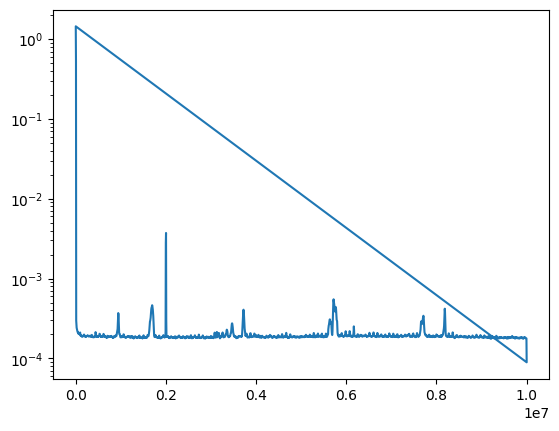

In [21]:
plt.semilogy(f_scratch, Pxx_scratch)

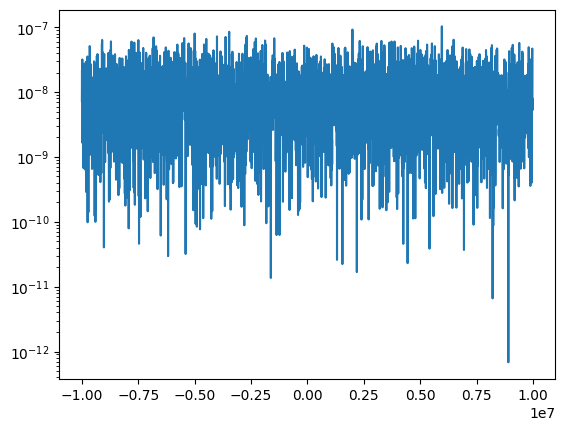

In [22]:
import scipy.signal as sig

f_sci, Pxx_sci = sig.periodogram(signal, fs=FS, window=WINDOW, nfft=NPERSEG)
f_sci, Pxx_sci = np.fft.fftshift(f_sci), np.fft.fftshift(Pxx_sci)
plt.semilogy(f_sci, Pxx_sci)
plt.show()